# Project-1: Candlestick Patterns


In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
from sklearn.metrics import accuracy_score

## Candlestick Charts

Candlestick charts visually represent stock price movements using four key values: **open**, **high**, **low**, and **close**. Each candlestick has two main parts:

1. **Body**: A rectangle representing the range between the **open** and **close** prices. 
   - If the **close** price is higher than the **open** price, it indicates that the stock price increased over the period, and the body is typically colored **green** (or white).
   - If the **close** price is lower than the **open** price, it shows that the stock price decreased, and the body is usually colored **red** (or black).

2. **Shadow/Wick**: A line extending from the body to represent the **high** and **low** prices.
   - The upper shadow extends from the top of the body to the **high** price, indicating the highest price reached within the time period.
   - The lower shadow extends from the bottom of the body to the **low** price, showing the lowest price reached.

This color-coded format helps investors quickly interpret market trends, with green candles indicating upward momentum and red candles indicating downward momentum.


![](pict/candlestick.png)

![](pict/cs_structure.png)

## Data
To identify the candlestick patterns, we will import Amazon's historical stock data for the period from January 1, 2020, to January 31, 2020. This dataset, referred to as training, will be used to identify patterns within it.

In [6]:
df_train = yf.Ticker('AMZN').history(start='2020-1-1', end='2020-1-31')
df_train.head().round(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,93.75,94.90,93.21,94.90,80580000,0.0,0.0
2020-01-03 00:00:00-05:00,93.22,94.31,93.22,93.75,75288000,0.0,0.0
2020-01-06 00:00:00-05:00,93.00,95.18,93.00,95.14,81236000,0.0,0.0
2020-01-07 00:00:00-05:00,95.22,95.69,94.60,95.34,80898000,0.0,0.0
2020-01-08 00:00:00-05:00,94.90,95.55,94.32,94.60,70160000,0.0,0.0


- In this project, the last three columns are not relevant and will therefore be removed.

In [8]:
df_train = df_train.iloc[:,:-3]
df_train.head().round(2)

,Open,High,Low,Close
Date,,,,
2020-01-02 00:00:00-05:00,93.75,94.90,93.21,94.90
2020-01-03 00:00:00-05:00,93.22,94.31,93.22,93.75
2020-01-06 00:00:00-05:00,93.00,95.18,93.00,95.14
2020-01-07 00:00:00-05:00,95.22,95.69,94.60,95.34
2020-01-08 00:00:00-05:00,94.90,95.55,94.32,94.60


- The following code converts the original index (dates) into a separate column named Date and assigns new integer-based indexes starting from 0, 1, 2, and so on

In [10]:
# reset index
df_train.reset_index(inplace=True)
df_train.head().round(2)

,Date,Open,High,Low,Close
0,2020-01-02 00:00:00-05:00,93.75,94.90,93.21,94.90
1,2020-01-03 00:00:00-05:00,93.22,94.31,93.22,93.75
2,2020-01-06 00:00:00-05:00,93.00,95.18,93.00,95.14
3,2020-01-07 00:00:00-05:00,95.22,95.69,94.60,95.34
4,2020-01-08 00:00:00-05:00,94.90,95.55,94.32,94.60


- Since the time component of the Date column values is not required, it will be removed.

In [12]:
df_train['Date'] = [i.date() for i in df_train.Date]
df_train.head().round(2)

,Date,Open,High,Low,Close
0,2020-01-02,93.75,94.90,93.21,94.90
1,2020-01-03,93.22,94.31,93.22,93.75
2,2020-01-06,93.00,95.18,93.00,95.14
3,2020-01-07,95.22,95.69,94.60,95.34
4,2020-01-08,94.90,95.55,94.32,94.60


- In the following code, *fcc* represents future close change from the current date to the next day, where:
    - $-1$ indicates a downward change (Down),
    - $0$ indicates no change (No change), and
    - $1$ indicates an upward change (Up).

In [14]:
# future close change
df_train['fcc'] = [np.sign(df_train.Close.loc[i+1]-df_train.Close.loc[i]) for i in range(len(df_train)-1)]+[np.nan]
df_train.head().round(2)

,Date,Open,High,Low,Close,fcc
0,2020-01-02,93.75,94.90,93.21,94.90,-1.0
1,2020-01-03,93.22,94.31,93.22,93.75,1.0
2,2020-01-06,93.00,95.18,93.00,95.14,1.0
3,2020-01-07,95.22,95.69,94.60,95.34,-1.0
4,2020-01-08,94.90,95.55,94.32,94.60,1.0


- In the first row, fcc is -1 because the current close value is 94.90, and the next day's close value is 93.75, indicating a decline in the closing price.

## Visualization

In [17]:
def cs_visualize(hp, op, cp, lp, x=0, details=False, linewidth=20):
    if cp > op: color = 'green'
    elif cp < op:  color = 'red'
    else: color ='black'

    plt.plot([x,x], [lp, hp], c=color)
    
    if cp != op:
        plt.plot([x,x], [op, cp], c=color, linewidth=linewidth)
    else:
        plt.plot([x-0.1,x+0.1], [op, cp], c=color, linewidth=1)

    if details:
        plt.text(x+0.01, hp, 'high')
        plt.text(x+0.01, lp , 'low')
        plt.text(x+0.01, cp, 'close')
        plt.text(x+0.01, op, 'open')

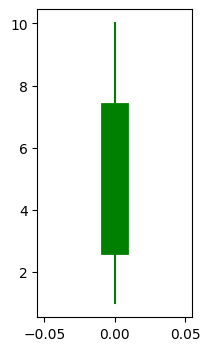

In [18]:
plt.figure(figsize=(2,4))
cs_visualize(hp=10, op=3, cp=7, lp=1, details=False, linewidth=20)

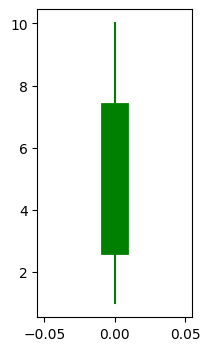

In [19]:
plt.figure(figsize=(2,4))
cs_visualize(hp=10, op=3, cp=7, lp=1, details=False, linewidth=20)

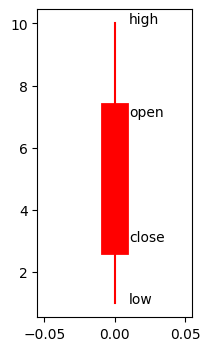

In [20]:
plt.figure(figsize=(2,4))
cs_visualize(hp=10, op=7, cp=3, lp=1, details=True, linewidth=20)

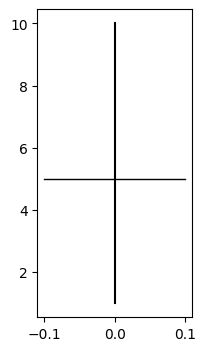

In [21]:
plt.figure(figsize=(2,4))
cs_visualize(hp=10, op=5, cp=5, lp=1)

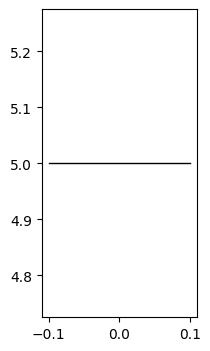

In [22]:
plt.figure(figsize=(2,4))
cs_visualize(hp=5, op=5, cp=5, lp=5)

In [23]:
def cs_visualize_df(data, M=0, N=None):
    plt.figure(figsize=(20,5))
    for i in data.index[M:N]:
        hp, op, cp, lp = data[['High','Open', 'Close', 'Low']].loc[i]
        cs_visualize(hp, op, cp, lp, x=i)

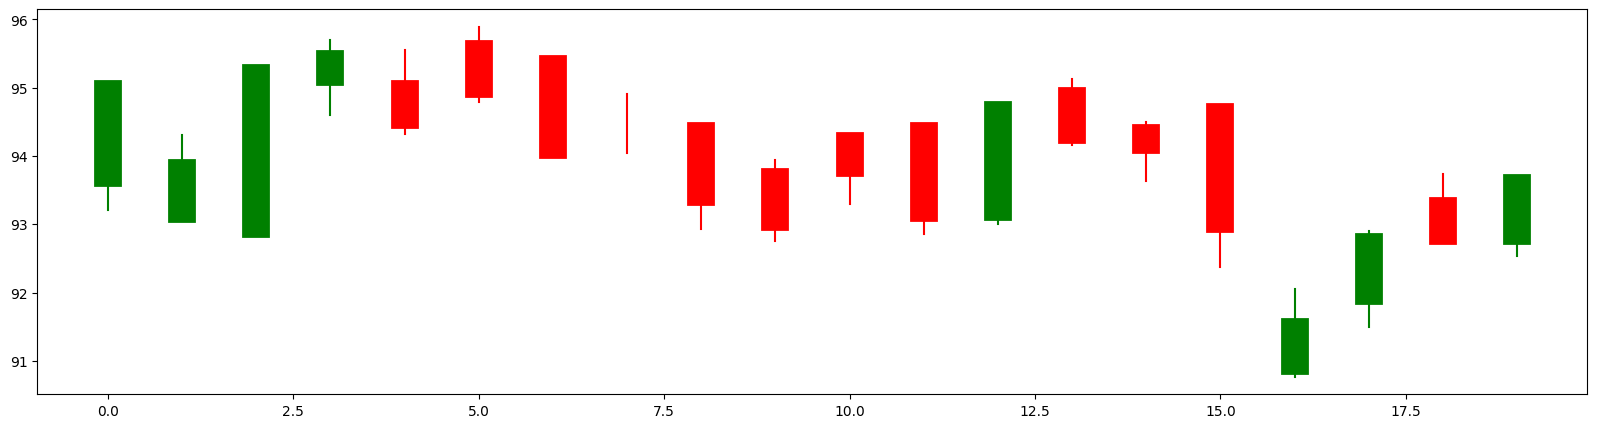

In [24]:
cs_visualize_df(df_train, M=0, N=None)

## Encoding
We will use the table below to encode the candlestick charts. If the open and close values are equal, the candlestick is referred to as a Doji.

|Condition|Code|Type|
|:-:|:-:|:-:|
|hp  >  op > cp  >  lp|a|Decreasing|  
|hp  =  op > cp  >  lp|b|Decreasing|
|hp  =  op > cp  =  lp|b|Decreasing|
|hp  >  op > cp  =  lp|d|Decreasing|
|hp  >  cp > op  >  lp|e|Increasing|
|hp  =  cp > op  >  lp|f|Increasing|
|hp  =  cp > op  =  lp|g|Increasing| 
|hp  >  cp > op  =  lp|h|Increasing| 
|hp  >  op = cp  >  lp|i|Doji| 
|hp  =  op = cp  >  lp|j|Doji|
|hp  =  op = cp  =  lp|k|Doji| 
|hp  >  op = cp  =  lp|l|Doji|


![](pict/encoding.png)

The code below generates an encoding for the given high, open, close, and low price values.

In [29]:
def encoder(hp, op, cp, lp):
    if hp  > op > cp  > lp: return 'a'
    if hp == op > cp  > lp: return 'b'
    if hp == op > cp == lp: return 'c'
    if hp  > op > cp == lp: return 'd'
        
    if hp  > cp > op  > lp: return 'e'
    if hp == cp > op  > lp: return 'f'
    if hp == cp > op == lp: return 'g'
    if hp  > cp > op == lp: return 'h'

    if hp  > op == cp  > lp: return 'i'
    if hp == op == cp  > lp: return 'j'
    if hp == op == cp == lp: return 'k'
    if hp  > op == cp == lp: return 'l' 

In [30]:
encoder(hp=10, op=4, cp=6, lp=1)

'e'

In [31]:
encoder(hp=10, op=6, cp=4, lp=1)

'a'

The following code takes a DataFrame as input and returns a new DataFrame with same data and an additional column that contains the encoded values for each corresponding row.

In [33]:
def df_encoder(data):
    data_ = data.copy()
    encoder_list = []
    for i in data_.index:
        hp, op, cp, lp = data_[['High','Open', 'Close', 'Low']].loc[i]
        encoder_list.append(encoder(hp, op, cp, lp))
    data_['code'] = encoder_list
    return data_

In [34]:
df_train = df_encoder(df_train)
df_train.head().round(2)

,Date,Open,High,Low,Close,fcc,code
0,2020-01-02,93.75,94.90,93.21,94.90,-1.0,f
1,2020-01-03,93.22,94.31,93.22,93.75,1.0,h
2,2020-01-06,93.00,95.18,93.00,95.14,1.0,h
3,2020-01-07,95.22,95.69,94.60,95.34,-1.0,e
4,2020-01-08,94.90,95.55,94.32,94.60,1.0,a


The chart below illustrates the candlestick charts along with their corresponding codes.

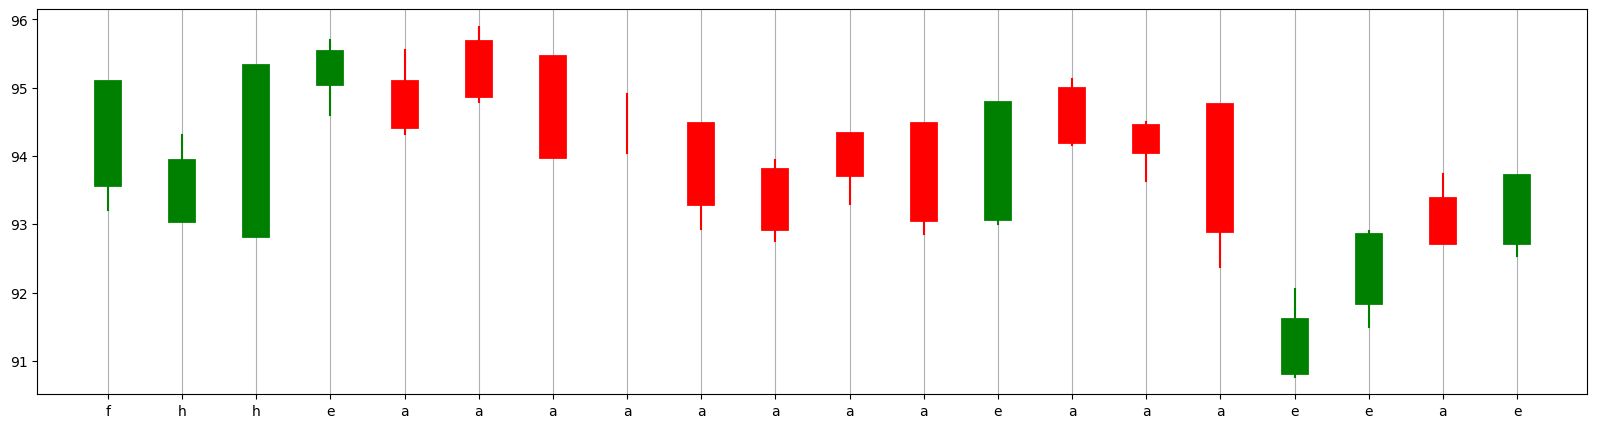

In [36]:
cs_visualize_df(df_train, M=0, N=None)
plt.xticks(range(len(df_train)), df_train.code)
plt.grid(axis='x');

## Change Points

Change points are the moments when the Close value changes its behavior. The six possible cases of behavior shifts are as follows:
- Up to Down
- Up to Equal
- Equal to Down
- Equal to Up
- Down to Equal
- Down to Up

**Remark:** The first day is also considered a change point.

The chart below displays 14 Close values. Points 1, 2, 3, 6, 9, 11, and 12 are identified as change points for the following reasons.
- 1: Starting point
- 2: Up to Equal
- 3: Equal to Up
- 6: Up to Down
- 9: Down to Up
- 11: Up to Down
- 12: Down to Up

![](pict/change_points.png)

In the following code:
- The change_points column holds boolean values (True for a change point and False for non-change points).
- The change_types column reflects the behavior of the Close value between consecutive days:
    - -1 indicates a "Down" movement (from the previous day to the current day).
    - 1 indicates an "Up" movement (from the previous day to the current day).
    - 0 indicates no change (the Close value stays equal from the previous day to the current day).

- A pair like (-1, -1) would mean the Close value has moved down from the previous day to the current day and continued to move down from the current day to the next day.

In [42]:
def change_points(data):
    data_ = data.copy()
    change_pts, change_types = [True], ['Start']

    for i in range(1, len(data_)-1):
        
        left_change  = int(np.sign(data_['Close'][i]-data_['Close'][i-1]))
        right_change = int(np.sign(data_['Close'][i+1]-data_['Close'][i]))
        
        if left_change != right_change:
            change_pts.append(True)
        else:
            change_pts.append(False)
            
        change_types.append((left_change, right_change))

    change_pts.append(False)
    change_types.append('End')

    data_['change_points'] = change_pts
    data_['change_types'] = change_types
    
    return data_

In [43]:
df_train = change_points(df_train)
df_train.head().round(2)

,Date,Open,High,Low,Close,fcc,code,change_points,change_types
0,2020-01-02,93.75,94.90,93.21,94.90,-1.0,f,True,Start
1,2020-01-03,93.22,94.31,93.22,93.75,1.0,h,True,"(-1, 1)"
2,2020-01-06,93.00,95.18,93.00,95.14,1.0,h,False,"(1, 1)"
3,2020-01-07,95.22,95.69,94.60,95.34,-1.0,e,True,"(1, -1)"
4,2020-01-08,94.90,95.55,94.32,94.60,1.0,a,True,"(-1, 1)"


In [44]:
df_train = change_points(df_train)
df_train.tail().round(2)

,Date,Open,High,Low,Close,fcc,code,change_points,change_types
15,2020-01-24,94.57,94.75,92.37,93.08,-1.0,a,False,"(-1, -1)"
16,2020-01-27,91.00,92.05,90.77,91.42,1.0,e,True,"(-1, 1)"
17,2020-01-28,92.03,92.91,91.50,92.66,1.0,e,False,"(1, 1)"
18,2020-01-29,93.20,93.74,92.75,92.90,1.0,a,False,"(1, 1)"
19,2020-01-30,92.90,93.64,92.53,93.53,NaN,e,False,End


In [45]:
def cp_visualizer(data, M=0, N=None):
    plt.figure(figsize=(20,5))
    plt.plot(data.index[M:N], data.Close[M:N], alpha=0.2)
    color_list = ['black', 'red']
    plt.scatter(data.index[M:N], data.Close[M:N], c=[color_list[i] for i in data.change_points[M:N]])
    plt.xticks(data.index[M:N], data.code[M:N], fontsize=12)
    plt.grid();

- In the graph of Close values below, the red points indicate the change points, while the x-values correspond to the candlestick code for each corresponding day.

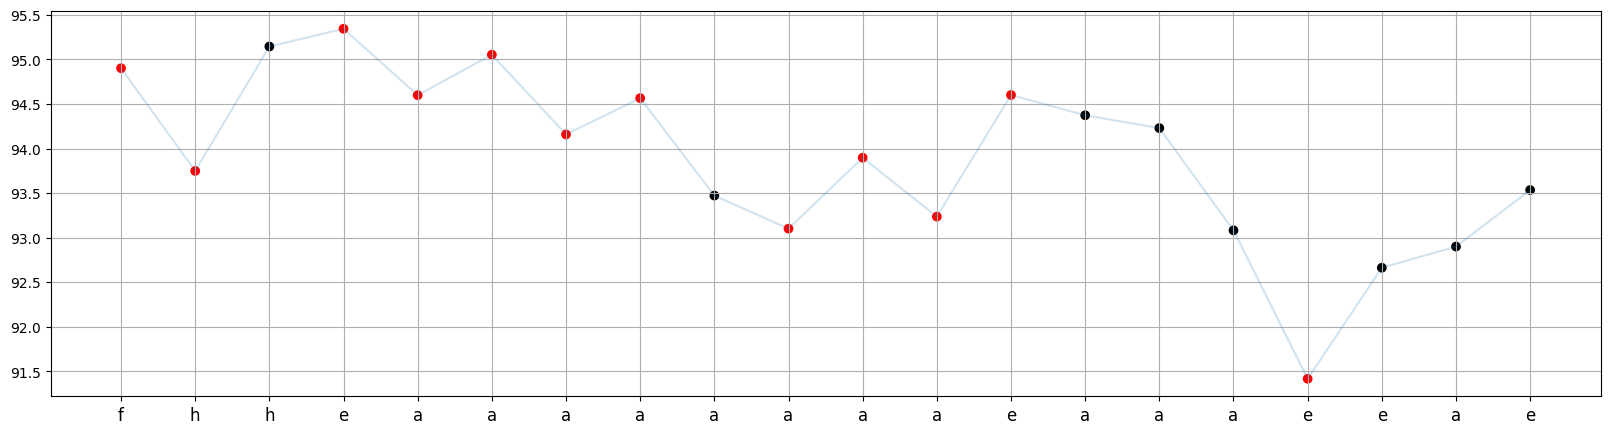

In [47]:
cp_visualizer(df_train, M=0, N=None)

## Segmentation and Labeling
The segmentation and labeling are based on the change points. 
- Each segment ends with a change point, and the chart below contains 7 segments.
    - Segment S-1 consists of only one point: 1.
    - Segment S-2 consists of only one point: 2.
    - Segment S-3 consists of only one point: 3.
    - Segment S-4 consists of three points: 4, 5, and 6 (change point).
    - Segment S-5 consists of three points: 7, 8, and 9 (change point).
    - Segment S-6 consists of two points: 10 and 11 (change point).
    - The last segment, S-7, consists of only one point: 12.


The label (called Trend in the paper) for each segment represents the direction of the next segment, as it reflects the future behavior that we aim to predict. Additionally, this label can be considered as the behavior immediately following the change point, representing the direction of movement after the change

- The Equal direction is not considered as a label, and instead, the first non-equal direction is taken as the label (or trend) for the segment. This applies to the second segment below:
    - The trend of S-1 is the direction from Point-1 to Point-2: Up (+1).
    - The trend of S-2 is the direction from Point-3 to Point-4, or the direction of S-4: Up (+1).
    - The trend of S-3 is the direction from Point-3 to Point-4, or the direction of S-4: Up (+1).
    - The trend of S-4 is the direction from Point-6 to Point-7, or the direction of S-5: Down (-1).
    - The trend of S-5 is the direction from Point-9 to Point-10, or the direction of S-6: Up (+1).
    - The trend of S-6 is the direction from Point-11 to Point-12: Down (-1).
    - The trend of S-7 is the direction from Point-12 to Point-13: Up (+1).

![](pict/segmentation.png)

### Terminology

- **K-line (k)**: Represents a single candlestick identified by its date, high, open, close, and low price values. It corresponds to a single letter in the coding system.  
  - Example: 'c'  and 'a' are examples of K-lines.

- **K-line Time Series (KTS)**: An ordered sequence of candlesticks, which can also consist of a single candlestick.  
  - Example: 'a', 'bbc', 'dd' are examples of K-Line Time Series.

- **K-line Pattern**: A pair consisting of a K-line Time Series (KTS) and its corresponding trend.  
  - Example: ('a', 1), ('bbc', -1), ('dd', -1) are examples of K-line patterns.

- **Pattern Set**: The collection of all K-line patterns within the training data.

### Coding

In [129]:
def segmentation(data):
    segment_list, trend_list = [], []
    pattern = ''
    
    for i in range(len(data)-1):  
        pattern += data.code[i]
    
        if data.change_points.loc[i]:
            segment_list.append(pattern) 
            j = i
            while True:
                if data.change_types[j+1][0] != 0:   # first non-equal direction
                    trend_list.append(data.change_types[j+1][0]) 
                    break
                j += 1
    
            pattern = ''

    df_seg = pd.DataFrame()
    df_seg['kts'] = segment_list
    df_seg['trend'] = trend_list

    df_seg_unique = pd.DataFrame(df_seg.value_counts()).reset_index()

    return df_seg_unique

In [51]:
PSet = segmentation(df_train)
PSet.head()

,kts,trend,count
0,a,-1,3
1,a,1,3
2,aa,1,1
3,aaae,1,1
4,e,-1,1


## Subsequence

In [53]:
def whethersub(X, Y):
    if len(X) > len(Y): return 0
    else:
        k = 0
        for i in range(len(X)):
            if X[i] in Y[k:]:
                k = Y.find(X[i], k)+1
            else:
                return 0          
    return 1 

In [54]:
whethersub('aec', 'abcde')

0

In [55]:
whethersub('ace', 'abcde')

1

In [56]:
whethersub('cd', 'abcde')

1

## oNum

In [58]:
def onum(pset):
    pset_ = pset.copy()
    onum_list = []
    for i in range(len(pset)):
        total = 0
        for j in range(len(pset)):
            total += whethersub(pset_.loc[i, 'kts'], pset_.loc[j, 'kts'])* pset_.loc[j, 'count']
        onum_list.append(total)
    pset_['onum'] = onum_list
    return pset_

In [59]:
PRSet = onum(PSet)
PRSet.head()

,kts,trend,count,onum
0,a,-1,3,8
1,a,1,3,8
2,aa,1,1,2
3,aaae,1,1,1
4,e,-1,1,3


## sameTrendNum

In [61]:
def sametrendnum(pset):
    pset_ = pset.copy()
    sametrendnum_list = []
    for i in range(len(pset_)):
        total = 0
        for j in range(len(pset_)):
            if whethersub(pset_.loc[i,'kts'], pset_.loc[j,'kts']) & (pset_.loc[i,'trend'] == pset_.loc[j, 'trend']):
                total += pset_.loc[j, 'count']    
        sametrendnum_list.append(total)
    pset_['sametrendnum'] = sametrendnum_list
    return pset_  

In [62]:
PRSet = sametrendnum(PRSet)
PRSet.head()

,kts,trend,count,onum,sametrendnum
0,a,-1,3,8,3
1,a,1,3,8,5
2,aa,1,1,2,2
3,aaae,1,1,1,1
4,e,-1,1,3,2


## PACC

In [64]:
def pacc(pset):
    pset_ = pset.copy()
    pset_['pacc'] = pset_['sametrendnum'] / pset_['onum'] 
    return pset_

In [65]:
PRSet = pacc(PRSet)
PRSet.head()

,kts,trend,count,onum,sametrendnum,pacc
0,a,-1,3,8,3,0.375000
1,a,1,3,8,5,0.625000
2,aa,1,1,2,2,1.000000
3,aaae,1,1,1,1,1.000000
4,e,-1,1,3,2,0.666667


## Subsequence Model

In [67]:
def subsequence_model_predict(kts, prset):
    best_pattern = []
    best_pacc = [0]
    best_trend = []
    for i in range(len(prset)):
        if (whethersub(prset.loc[i, 'kts'], kts)):
            if prset.loc[i, 'pacc'] > best_pacc[-1]:
                best_pattern = [prset.loc[i, 'kts']] 
                best_pacc = [prset.loc[i, 'pacc']]
                best_trend = [ prset.loc[i, 'trend']]
            elif prset.loc[i, 'pacc'] == best_pacc[-1]:
                best_pattern.append(prset.loc[i, 'kts'])
                best_pacc.append(prset.loc[i, 'pacc'])
                best_trend.append(prset.loc[i, 'trend'])

    if len(best_trend) == 0:
        pred = statistics.mode(prset.trend)
    elif len(best_trend) == 1:
        pred = best_trend[0]
    else:
        pred = statistics.mode(best_trend)
        
    return {'Best Pattern':best_pattern, 'Best PACC': best_pacc, 'Best Trend': best_trend, 'Prediction':pred}

In [68]:
subsequence_model_predict('aaee', PRSet)

{'Best Pattern': ['aa'],
 'Best PACC': [1.0],
 'Best Trend': [1],
 'Prediction': 1}

In [69]:
subsequence_model_predict('acd', PRSet)

{'Best Pattern': ['a'],
 'Best PACC': [0.625],
 'Best Trend': [1],
 'Prediction': 1}

## Test Set

In [71]:
df_test = yf.Ticker('AMZN').history(start='2020-2-1', end='2020-2-28')
df_test.reset_index(inplace=True)
df_test = df_test.iloc[:,:-3]
df_test['Date'] = [i.date() for i in df_test.Date]
df_test = df_encoder(df_test)
df_test = change_points(df_test)
df_test['fcc'] = [np.sign(df_test.Close.loc[i+1]-df_test.Close.loc[i]) for i in range(len(df_test)-1)]+[np.nan]
df_test.head()

,Date,Open,High,Low,Close,code,change_points,change_types,fcc
0,2020-02-03,100.529999,102.425003,100.012497,100.209999,a,True,Start,1.0
1,2020-02-04,101.494003,102.989998,100.768501,102.483498,e,True,"(1, -1)",-1.0
2,2020-02-05,103.551003,103.551003,101.599998,101.993500,b,True,"(-1, 1)",1.0
3,2020-02-06,102.051003,102.815002,101.239998,102.511497,e,False,"(1, 1)",1.0
4,2020-02-07,102.099503,104.926498,101.904999,103.963997,e,False,"(1, 1)",1.0


In [72]:
def test_data_prep(data, N=5):
    test_data = []
    for i in range(len(data)-N):
        kts = ''
        for j in range(N):
            kts += data.code.loc[i+j]
        test_data.append((kts, data.fcc.loc[i+j]))
        
    if type(test_data[-1][-1]) != float:
        test_data.pop()
    
    return test_data

In [73]:
test_data = test_data_prep(df_test)
test_data

[('aebee', 1.0),
 ('ebeee', 1.0),
 ('beeea', 1.0),
 ('eeeaa', -1.0),
 ('eeaae', -1.0),
 ('eaaea', 1.0),
 ('aaeae', 1.0),
 ('aeaee', -1.0),
 ('eaeea', -1.0),
 ('aeeaa', -1.0),
 ('eeaae', -1.0),
 ('eaaea', 1.0)]

## Prediction

In [75]:
def subsequence_model_score(data, prset):
    pred_test = [subsequence_model_predict(kts, prset)['Prediction'] for (kts,trend) in data]
    return accuracy_score(pred_test, [trend for (kts,trend) in data])

In [76]:
subsequence_model_score(test_data, PRSet)

0.25